In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord

In [2]:
# Data for M67
data = fits.getdata("M67.fits.gz")

In [3]:
'132.846	+11.814 	0.166 	598	-10.986 	-2.964 	1.135	NN 	9.63 	0.07 	9.75 	889 	-613 	-440 	470 	8964'.split('\t')

['132.846',
 '+11.814 ',
 '0.166 ',
 '598',
 '-10.986 ',
 '-2.964 ',
 '1.135',
 'NN ',
 '9.63 ',
 '0.07 ',
 '9.75 ',
 '889 ',
 '-613 ',
 '-440 ',
 '470 ',
 '8964']

In [4]:
# Parameters for M67: https://dx.doi.org/10.1051/0004-6361/201833476, http://dx.doi.org/10.1051/0004-6361/202038192
r50 = 10 * u.arcmin
ra_c = 132.846
dec_c = 11.814

In [5]:
plt.style.use("report.mplstyle")

In [6]:
# Astrometry
ra = data['ra']
dec = data['dec']

pmra = data['pmra']
pmdec = data['pmdec']

parallax = data['parallax']
e_parallax = data['parallax_error']

In [7]:
# Photometry
g = data['phot_g_mean_mag']
g_rp = data['g_rp']

In [8]:
# Systematics
ruwe = data['ruwe']
aen = data['astrometric_excess_noise']
aen_sigma = data['astrometric_excess_noise_sig']

In [9]:
g_flux = data['phot_g_mean_flux']
size = g_flux/np.nanmax(g_flux) * 100

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


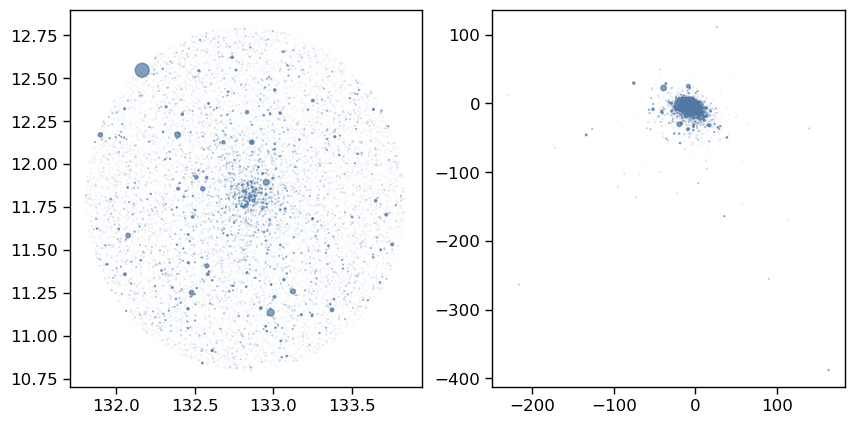

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(ra, dec, s=size, alpha=0.7)

plt.subplot(122)
plt.scatter(pmra, pmdec, s=size, alpha=0.7)

Text(0, 0.5, '$\\mu_\\delta$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['TeX Gyre Chorus'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Tex Gyre Pagella'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Inconsolata'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Tex Gyre Pagella'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Tex Gyre Pagella'] not found. Falling back to DejaVu Sans.


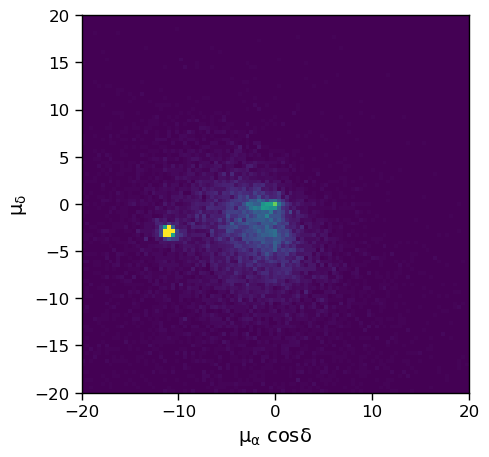

In [11]:
plt.hist2d(pmra, pmdec, bins=np.linspace(-20, 20, 100), vmin=0, vmax=100);
plt.xlabel(r"$\mu_\alpha\ \cos \delta$")
plt.ylabel(r"$\mu_\delta$")
# plt.colorbar()

In [12]:
sel_plx = (parallax - 1/0.889) > 3 * e_parallax
sel_ruwe = ruwe > 1.4
sel_aen = (aen>1)
sel_pm = np.isnan(pmra) | np.isnan(pmdec)

In [13]:
sel_good_astrometry = ~(sel_plx | sel_ruwe | sel_aen | sel_pm)

In [14]:
obs_coords = SkyCoord(ra, dec, unit='deg')
cluster_coords = SkyCoord(ra_c, dec_c, unit='deg')

## Generate training set for PRF

In [15]:
sel_r50 = (cluster_coords.separation(obs_coords) < r50)
sel_train = sel_good_astrometry & sel_r50

In [16]:
mu = np.c_[pmra, pmdec][sel_train]

In [17]:
def univariate_gaussian(x, A, mu, sig):
    """Un-normalized Gaussian"""
    return A * np.exp(-(x - mu)**2 / (2 * sig**2))


def multivariate_gaussian(X, mu, Sigma):
    """Multivariate Gaussian distribution"""
    k = mu.shape[0]

    V = np.linalg.inv(Sigma)
    norm = np.sqrt((2 * np.pi)**k * np.linalg.det(Sigma))

    res = X - mu

    return 1 / norm * np.exp(-1 / 2 * np.einsum('...j,jk,...k', res, V, res))

In [18]:
# Cluster
w_c = 0.5
mu_c = np.array([-11,-3])
Sigma_c = np.array([[1, 0], [0, 1]])

# Field
w_f = 1 - w_c
mu_f = np.array([-5, 0])
Sigma_f = np.array([[400, 0], [0, 400]])

In [19]:
for i in range(100):
    pm_dist_c = w_c * multivariate_gaussian(mu, mu_c, Sigma_c)
    pm_dist_f = w_f * multivariate_gaussian(mu, mu_f, Sigma_f) 
    pm_dist = pm_dist_c + pm_dist_f

    member_probability = pm_dist_c/pm_dist
    field_probability = pm_dist_f/pm_dist

    w_c = np.sum(member_probability)/mu.shape[0]
    mu_c = np.average(mu, weights=member_probability, axis=0)
    Sigma_c = np.einsum('ji,ik->jk', member_probability*(mu-mu_c).T, mu-mu_c)/member_probability.sum()

    w_f = np.sum(field_probability)/mu.shape[0]
    mu_f = np.average(mu, weights=field_probability, axis=0)
    Sigma_f = np.einsum('ji,ik->jk', field_probability*(mu-mu_f).T, mu-mu_f)/field_probability.sum()

In [20]:
mu_c

array([-10.98202566,  -2.90048095])

In [21]:
mu_f

array([-2.91346269, -4.12584087])

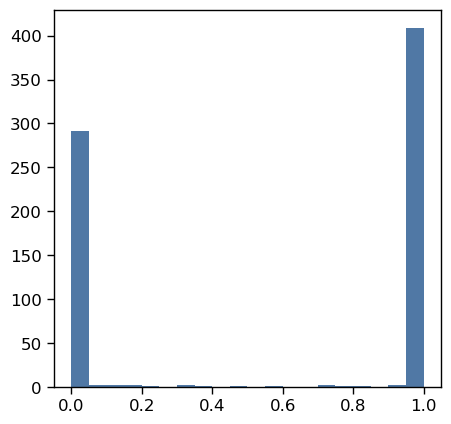

In [22]:
plt.hist(member_probability, bins=20);

In [23]:
member_cluster = member_probability > 0.5

(-20.0, 20.0)

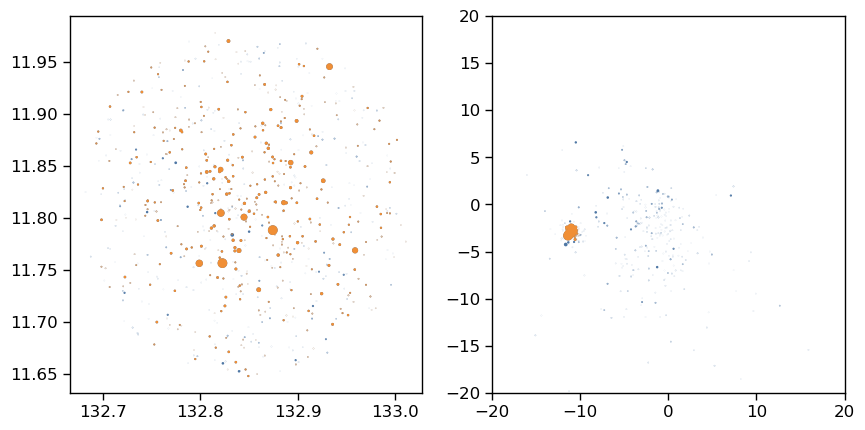

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(ra[sel_train],
            dec[sel_train],
            s=size[sel_train] * 10)
plt.scatter(ra[sel_train][member_cluster],
            dec[sel_train][member_cluster],
            s=size[sel_train][member_cluster] * 10)

plt.subplot(122)
plt.scatter(pmra[sel_train],
            pmdec[sel_train],
            s=size[sel_train] * 10)
plt.scatter(pmra[sel_train][member_cluster],
            pmdec[sel_train][member_cluster],
            s=size[sel_train][member_cluster] * 10)
plt.xlim(-20,20)
plt.ylim(-20,20)

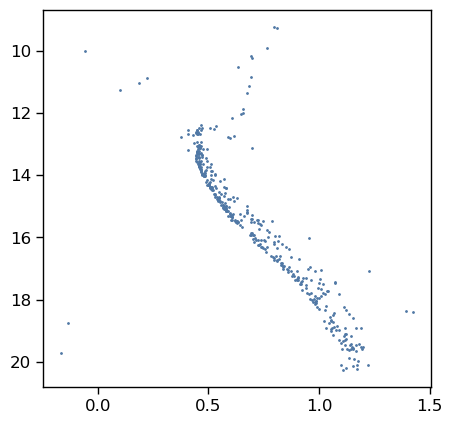

In [25]:
plt.scatter(g_rp[sel_train][member_cluster], g[sel_train][member_cluster], s=1)
plt.gca().invert_yaxis()

In [26]:
training_data = data[sel_train]

In [27]:
from astropy.table import Table

In [28]:
tab = Table(training_data)

In [29]:
tab.add_column(member_cluster.astype("int"), name='Class')
pmr0 = np.linalg.norm(mu-mu_c, axis=1)
tab.add_column(pmr0, name='pmrzero')

In [30]:
tab.write("Train_M67_csv.dat", format='csv', overwrite=True)

In [31]:
import pandas as pd
data= pd.read_csv("Train_M67_csv.dat")
# data.head()
cols = data.columns
#shuffuling the data
# new_data = data.sample(frac=1)


F_10 = ['ra','dec','parallax','pmra','pmdec','pmrzero','g_rp','phot_g_mean_mag','ruwe','astrometric_excess_noise']
# F_10 = ['ra']
print(len(F_10))
data_cols = F_10 + ['Class']

data = data[data_cols]
data.head()

10


,ra,dec,parallax,pmra,pmdec,pmrzero,g_rp,phot_g_mean_mag,ruwe,astrometric_excess_noise,Class
0,132.930610,11.670291,0.397002,-4.716661,1.045636,7.404501,0.455221,16.243813,1.050594,0.114471,0
1,132.858490,11.649711,1.335188,-10.238927,-3.325564,0.856090,NaN,18.204634,1.037907,0.357743,1
2,132.828189,11.654099,1.118802,-11.270391,-2.332732,0.636783,1.100828,19.398100,1.017989,0.632820,1
3,132.823281,11.660013,0.972956,-8.253676,-0.838853,3.419678,0.454341,13.424560,0.990332,0.000000,0
4,132.849407,11.647809,1.172834,-10.977122,-2.842882,0.057807,0.505973,14.370622,0.947316,0.000000,1


In [35]:
FRAC = 3/4
split = int(len(data)*FRAC) -1

train_data = data.iloc[:split]
test_data = data.iloc[split:]

train_data.dropna()
test_data.dropna()

X_train = train_data[F_10]
y_train = train_data['Class']

X_test = test_data[F_10]
y_test = test_data['Class']

# print(len(X_test), len(X_train))

# X_train = X_train.dropna()
# X_test = X_test.dropna()
# print(len(X_test), len(X_train))

In [36]:
X_train = X_train.values
X_test = X_test.values
# print(len(X_test), len(X_train))
# print(X_train, X_test)

In [ ]:
import warnings; warnings.simplefilter('ignore')

import PRF
from tqdm import tqdm

def prf_res(n_trees=10, keep_prob=0.05):
    prf_cls = PRF.prf(n_estimators=n_trees,  bootstrap=True, keep_proba=keep_prob)
    prf_cls.fit(X=X_train, y=y_train)
    a = prf_cls.score(X=X_test, y=y_test)
    return a
    
prf_results = []
    
for i in tqdm(range(10,300,10)):
    prf_tr = []
    for j in range(1,1000,10):
        prf_tr.append([i,j/1000, prf_res(n_trees=i, keep_prob=j/1000)])

  7%|▋         | 2/29 [00:34<08:06, 18.02s/it]